<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative_VGG16_26102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project:** Posgraduate Business Intelligence Master PUC-RJ 2021

# **Classification and Prediction of rocks images in drilled wells via Learning Methods Supervised by deep learning and pre trained models**

# **1. Overview of files**

**geological_similarity/: stores the images of the 6 types of rocks: **   

* andesite/:rock images directory andesite;
*   gneiss/:rock images directory gneiss;
*   marble:rock images directory marble;
*   quartzite:rock images directory quartzite;
*   rhyolite:rock images directory rhyolite
*   schist:drock images directory schist;

    
Este trabalho se concentrará na análise ....

In [1]:
# Import from libraries

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
from os import getcwd

import tensorflow as tf
import zipfile
import sys
import shutil
import numpy as np
import glob
import random
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split

In [2]:
# If necessary, use this code below:

# Install Tensorflow
#!pip install tensorflow==2.6.0
# Install Keras
#!pip install keras --upgrade

In [3]:
#versao2-colab.py
#Imprime versao de Tensorflow, Keras e Keras dentro do Tensorflow
#Tambem imprime se GPU esta funcionando, versao de SO, CPU e RAM
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# Devido a bug, pode ser necessario colocar o comando abaixo, 
# quando da erro "Failed to get convolution algorithm"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("Versao python3:",sys.version)
print("Versao de tensorflow:",tf.__version__)
print("Versao de Keras independente:",tf.keras.__version__)
print("Versao de Keras dentro de tensorflow:",tf.keras.__version__)
print("Versao cv2:",cv.__version__)
os.system("nvcc --version | grep release")
print()

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
  !cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!cat /proc/cpuinfo | grep -E "model name" #especificações de CPU
!cat /proc/meminfo  | grep "Mem" #especificações de RAM
print()

import torch;
print("Versao pytorch: ",torch.__version__);
print("GPU disponivel em pytorch: ",torch.cuda.is_available());

Versao python3: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Versao de tensorflow: 2.6.0
Versao de Keras independente: 2.6.0
Versao de Keras dentro de tensorflow: 2.6.0
Versao cv2: 4.1.2

Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7']
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"

No LSB modules are available.
Description:	Ubuntu 18.04.5 LTS
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
MemTotal:       13302924 kB
MemFree:         9121260 kB
MemAvailable:   12035324 kB

Versao pytorch:  1.9.0+cu111
GPU disponivel em pytorch:  True


In [4]:
# If necessary, remove the directories

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
#!rm -rf geological_similarity


# **2. Extraction, Transformation and Loading of the Data**

## **2.1. Kaglle Data Collection**

In [5]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.

#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity   

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.': No such file or directory
 69% 23.0M/33.6M [00:00<00:00, 83.4MB/s]
100% 33.6M/33.6M [00:00<00:00, 110MB/s] 


# **Creating the directory structure**

In [6]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))

andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)


5000
5000
4998
5000
5000
5000


29998

# **Creation of Parameters**

In [7]:
INIT_LR = 1e-3
EPOCHS = 200
BS=24
SEED = 999
np.random.seed(SEED)

# **Dataframe Creation**

In [8]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/rhyolite/8N0DB.jpg,rhyolite
1,geological_similarity/andesite/KMRXP.jpg,andesite
2,geological_similarity/marble/J0WLG.jpg,marble
3,geological_similarity/marble/7IIK9.jpg,marble
4,geological_similarity/gneiss/GG7DB.jpg,gneiss
...,...,...
29993,geological_similarity/schist/Y85JJ.jpg,schist
29994,geological_similarity/marble/5GG7Y.jpg,marble
29995,geological_similarity/gneiss/5B5XA.jpg,gneiss
29996,geological_similarity/quartzite/4126T.jpg,quartzite


# **Convert the images to 32 by 32**

In [9]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

# Convert data and labels to NumPy arrays while scaling the pixel
dados = np.array(dados) 
labels = np.array(labels)
labels

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


array(['rhyolite', 'andesite', 'marble', ..., 'gneiss', 'quartzite',
       'marble'], dtype='<U9')

# **Renaming labels from string format to int**

In [10]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)

[[0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]]


# **Creating the Dataframe on Training, Validation and Testing Data**

In [11]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


# **Normalization**

In [12]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Knowing Image Data**

In [14]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Data cleaning**
1 - Analyzing missing data
2 - Discarding missing data
3 - Imputing data
4 - Adding informative columns

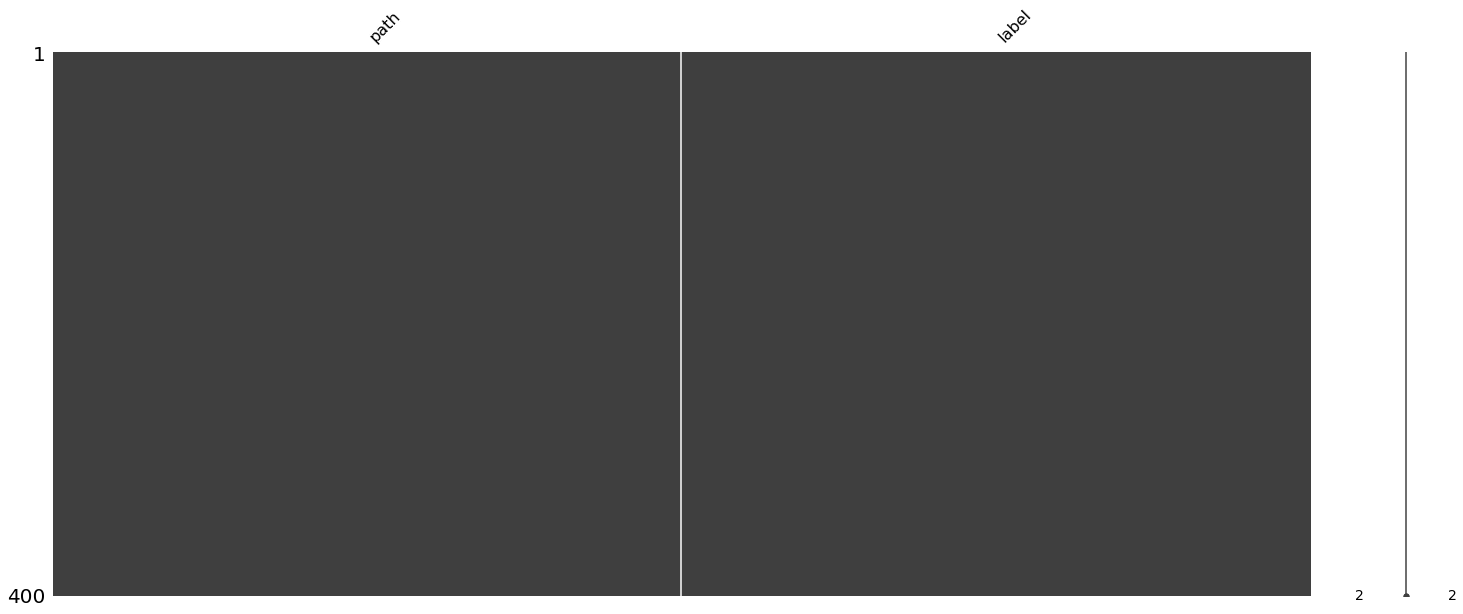

In [15]:
### 1 - Analyzing missing ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

# **Exploring the data**


# **Type: Data Augumentation**

## ** This function will plot the images in a 1 to 5 column grid **

In [16]:
IMG_SHAPE = 32

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [17]:
# Creating the Training and Validation data

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)

In [18]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [19]:
# Test Data

datagen_test = ImageDataGenerator (rescale=1./255, 
                                   #validation_split=0.8,
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation')

Found 29998 validated image filenames belonging to 6 classes.


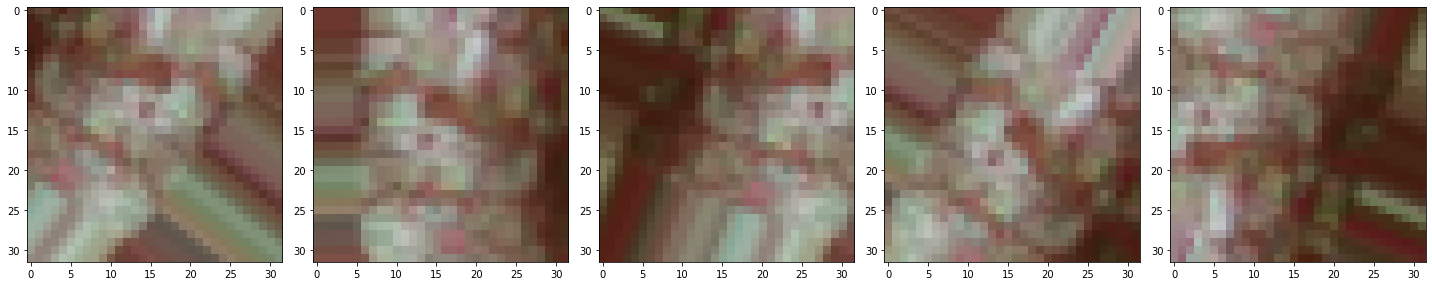

In [20]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [21]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

test_generator.class_indices.keys()

#X_test, y_test = next(test_generator) # não utilizado

dict_keys(['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist'])

# **Perform predictions for classes with the created model**

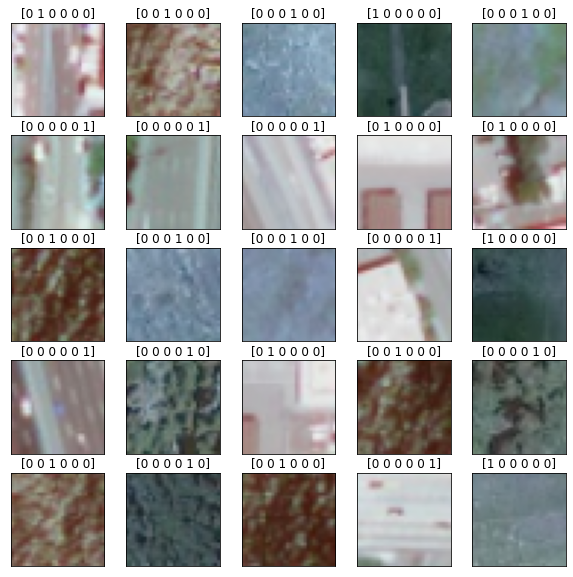

In [22]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    #plt.xlabel(y_train[i])
plt.show()
   

# **Listing the networks actually available in your Keras**

In [23]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **The pre-trained VGG16 Model**
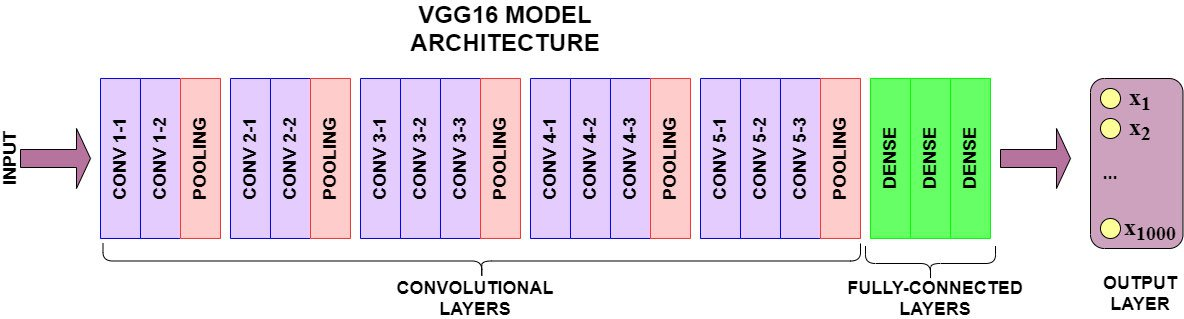

In [24]:
classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 1s 0us/step


In [25]:
# List VGG16 Model Layers
for i,layer in enumerate(classifier.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [26]:
# Marcar as camadas como não treináveis
#for layer in classifier.layers:
   # layer.trainable = False

for layer in classifier.layers[:-2]:
  layer.trainable = False
  print(layer)

# Create a new model
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = datagen (inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 , offset=-1)
x = scale_layer(inputs)

# Add new layers for classification

x = classifier(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Regularize with dropout
output = Dense(6, activation='softmax')(x)

#flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
#flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
#flat1 = tf.keras.layers.Dropout(0.5)(flat1)
#output = Dense(6, activation='softmax')(flat1)

# The model
modelvgg16 = Model(inputs=inputs, outputs=output)

modelvgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

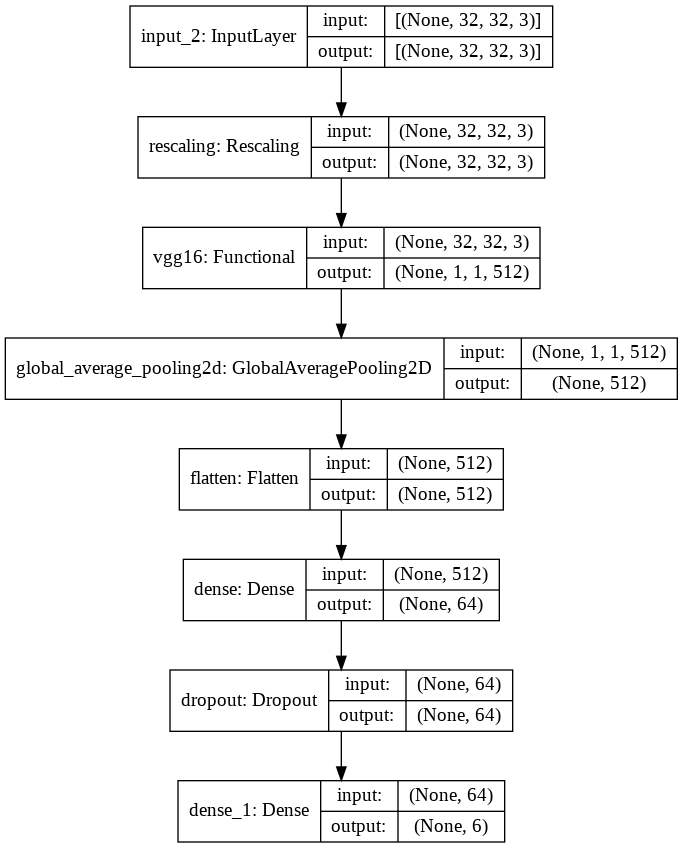

In [27]:
tf.keras.utils.plot_model(modelvgg16, show_shapes=True)

In [28]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/My Drive/models/feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
        #save_weights_only=False,
        mode='max',
        #period=1,
    ),
     # Write TensorBoard logs to './logs' directory
    tf.keras.callbacks.TensorBoard(log_dir='./tmp')

]

In [ ]:
historyvgg16 = modelvgg16.fit(X_train,y_train,
                    batch_size=BS,
                    epochs=EPOCHS,
                    verbose=1,
                    steps_per_epoch = len(X_train)//BS,
                    callbacks=callbacksvgg16,
                    validation_data=(X_val,y_val),
                    validation_steps = len(X_val) //BS)

Epoch 1/200
749/749 [==============================] - 51s 27ms/step - loss: 0.4838 - accuracy: 0.8330 - val_loss: 0.2113 - val_accuracy: 0.9288
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.vgg16/assets
Epoch 2/200
749/749 [==============================] - 22s 28ms/step - loss: 0.2614 - accuracy: 0.9092 - val_loss: 0.1709 - val_accuracy: 0.9390
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.vgg16/assets
Epoch 3/200
749/749 [==============================] - 21s 28ms/step - loss: 0.2122 - accuracy: 0.9263 - val_loss: 0.1417 - val_accuracy: 0.9477
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.vgg16/assets
Epoch 4/200
749/749 [==============================] - 21s 28ms/step - loss: 0.1928 - accuracy: 0.9330 - val_loss: 0.1325 - val_accuracy: 0.9522
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.vgg16/assets
Epoch 5/200
749/749 [=======

# **Save the model VGG16**

In [ ]:
# tf.keras.models.save_model(modelvgg16,'/content/drive/My Drive/models/feature_extraction.vgg16')

In [ ]:
from keras.models import model_from_json

def save_model(model):
    # saving model
    json_model = model.to_json()
    open('/content/drive/My Drive/models/model_vgg16.json', 'w').write(json_model)
    # saving weights
    model.save_weights('/content/drive/My Drive/models/vgg16_weights.h5', overwrite=True)

In [ ]:
def load_model():
    # loading model
    modelvgg16 = model_from_json(open('/content/drive/My Drive/models/model_vgg16.json').read())
    modelvgg16.load_weights('/content/drive/My Drive/models/vgg16_weights.h5')
    modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy']) 
    return modelvgg16

In [ ]:
# save the model
save_model(modelvgg16)

# **Let's plot the training and validation accuracy as well as the loss.**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./tmp


# **Evaluate Model Accuracy**

In [ ]:
# (ref http://stackoverflow.com/q/32239577/395857)

def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_predVGG16[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
#modelvgg16 = tf.keras.models.load_model("/content/drive/My Drive/models/feature_extraction.vgg16")
# load the model
modelvgg16 = load_model()

y_predVGG16 = modelvgg16.predict(X_test,batch_size=BS)

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_accvgg16))

print("-------\n")

print(f"Test accuracy: {test_accvgg16}")
print(f"Test loss: {test_lossvgg16}")

print("-------\n")

# In such a situation, Hamming loss is a good measure of model performance.
# Decrease Hamming loss, better model performance.
# For the above labels, Hamming loss is 0.XXX as calculated below.

hs = hamming_score(y_test, y_predVGG16)
print(f"Hamming loss: {hs}")
print("-------\n")

# **Pre-trained VGG16 Model Predictions**

In [ ]:
#y_predVGG16 = modelvgg16.predict(X_test)
print("Prediction_accuracy: " + str(y_predVGG16))

In [ ]:
y_predVGG16[300]

In [ ]:
print(np.argmax(y_predVGG16[300]))  #Class 1

In [ ]:
# prediction is correct - Class 0, as shown below:
plt.figure()
plt.imshow(X_train[300])
plt.xlabel(y_test[300])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
print("[INFO] evaluating network...")
#y_predVGG16 = modelvgg16.predict(X_test,batch_size=BS)

y_predVGG16 = np.argmax(y_predVGG16, axis=1)

print(classification_report(y_test.argmax(axis=1), y_predVGG16,
                            target_names=lb))

# **The confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

cmvgg16 = confusion_matrix(y_test.argmax(axis=1),y_predVGG16)

# show the confusion matrix
#print(cmvgg16)

cm_matrix = pd.DataFrame(data=cmvgg16, columns=['andesite','gneiss','marbler','quartzite','rhyolite','schist'], 
                                 index=['andesite','gneiss','marbler','quartzite','rhyolite','schist'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Calcule a matriz de confusão e use-a para derivar o
# precisão, sensibilidade e especificidade

total = sum(sum(cmvgg16))
acc = (cmvgg16[0, 0] + cmvgg16[1, 1]) / total
sensitivity = cmvgg16[0, 0] / (cmvgg16[0, 0] + cmvgg16[0, 1])
specificity = cmvgg16[1, 1] / (cmvgg16[1, 0] + cmvgg16[1, 1])

# Mostrar a precisão, sensibilidade e especificidade
print("acc: {:.4f}".format(acc))

# **Confusion matrix with heat map**

In [ ]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

scratch_preds = modelvgg16.predict(test_generator)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

vgg_preds = modelvgg16.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
# Get the names of the ten classes
class_names1 = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names1, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names1, 
        yticklabels=class_names1,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

#fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
fig, (ax1) = plt.subplots(1,1,figsize=(20, 10))

#plot_heatmap(true_classes, scratch_pred_classes, class_names1, ax1, title="Custom ")    
plot_heatmap(true_classes, vgg_pred_classes, class_names1, ax1, title="Transfer Learning (VGG16)")    